In [44]:
from torchvision.ops import box_iou
import os
import pandas as pd
import json
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [45]:
BASE_DIR = "/home/safal/raavan/smartphone_microscopy/AI_assisted_microscopy_system"
sample_types = [
    "smartphone_sample",
    "smartphone_reference",
    "brightfield_sample",
    "brightfield_reference",
]
model_type = "retinanet"
sample_type = sample_types[2]
fold = 1


In [46]:
pred_annotation_file = os.path.join(
    BASE_DIR, "outputs", sample_type, model_type, f"fold_{fold}", "results.bbox.json"
)
gt_annotation_file = os.path.join(
    BASE_DIR,
    "cysts_dataset_all",
    sample_type,
    f"fold_{fold}",
    f"{sample_type}_coco_annos_val.json",
)


In [47]:
def calculate_precision_recall_f1(
    pred_annotations_file,
    gt_annotations_file,
    conf_threshold: float = 0.3,
    iou_threshold: float = 0.5,
):
    """
    This function calculates the precision, recall and f1 score for each class
    in the given ground truth and predicted annotations.

    Arguments:
        pred_annotations_file: path to the predicted annotations file
        gt_annotations_file: path to the ground truth annotations file
        conf_threshold: confidence threshold to filter out predictions

    Returns:
        metrics_df: dataframe containing the precision, recall and f1 score for each class

    """
    # Precision x Recall is obtained individually by each class
    # Loop through each class and calculate the precision and recall

    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    with open(gt_annotations_file) as f:
        gt_annotations = json.load(f)

    with open(pred_annotations_file) as f:
        pred_annotations = json.load(f)

    gt_annotations_df = pd.DataFrame(gt_annotations["annotations"])
    pred_annotations_df = pd.DataFrame(pred_annotations)

    # change bbox width and height to x2, y2
    pred_annotations_df["bbox"] = pred_annotations_df["bbox"].apply(
        lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]]
    )
    gt_annotations_df["bbox"] = gt_annotations_df["bbox"].apply(
        lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]]
    )

    categories = sorted(gt_annotations_df.category_id.unique())

    # dataframe to store the precision, recall and f1 score for each class
    metrics_df = pd.DataFrame(
        columns=["category", "precision", "recall", "f1_score", "TP", "FP"]
    )

    for category in categories:
        # get the ground truth annotations for the current class
        gt_annotations_df_class = gt_annotations_df[
            gt_annotations_df.category_id == category
        ]
        # get the predicted annotations for the current class
        pred_annotations_df_class = pred_annotations_df[
            pred_annotations_df.category_id == category
        ]

        # sort the predicted annotations by score
        pred_annotations_df_class = pred_annotations_df_class.sort_values(
            by="score", ascending=False
        )

        # filter predictions with score > conf_threshold
        pred_annotations_df_class = pred_annotations_df_class[
            pred_annotations_df_class.score > conf_threshold
        ]

        true_positives_class = 0
        false_positives_class = 0

        # get image ids for the current class from both ground truth and predicted annotations
        image_ids = pred_annotations_df_class["image_id"].unique()

        for image in image_ids:
            # get the ground truth annotations for the current image
            gt_annotations_df_image = gt_annotations_df_class[
                gt_annotations_df_class.image_id == image
            ]
            # get the predicted annotations for the current image
            pred_annotations_df_image = pred_annotations_df_class[
                pred_annotations_df_class.image_id == image
            ]

            # get the ground truth bounding boxes
            gt_bboxes = torch.tensor(gt_annotations_df_image.bbox.to_list())

            gt_matched = np.zeros(len(gt_bboxes))

            # get the predicted bounding boxes
            pred_bboxes = torch.tensor(pred_annotations_df_image.bbox.to_list())
        

            if len(gt_bboxes) == 0:
                false_positives_class += len(pred_bboxes)
                continue

            # get the intersection over union for each predicted bounding box
            ious = box_iou(pred_bboxes, gt_bboxes)

            # get the maximum iou for each ground truth bounding box
            max_ious, max_idxs = torch.max(ious, dim=1)

            for iou_pred, gt_idx in zip(max_ious, max_idxs):
                if (iou_pred > iou_threshold).item() and (gt_matched[gt_idx] == 0):
                        true_positives_class += 1
                        gt_matched[gt_idx] = 1
                else:
                    false_positives_class += 1


        # calculate the precision and recall
        eps = torch.finfo(torch.float32).eps
        precision = true_positives_class / max(
            true_positives_class + false_positives_class, eps
        )
        recall = true_positives_class / max(gt_annotations_df_class.shape[0], eps)

        category_name = gt_annotations["categories"][category]["name"]
        f1_score = 2 * (precision * recall) / max(precision + recall, eps)

        category_metrics_df = pd.DataFrame(
            {
                "category": category_name,
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score,
                "TP": true_positives_class,
                "FP": false_positives_class,
            },
            index=[0],
        )

        # concatenate the metrics for the current class to the metrics dataframe
        metrics_df = pd.concat([metrics_df, category_metrics_df], axis=0)

    return metrics_df

In [48]:
confidence_thresholds = np.arange(0.1, 1.0, 0.1)
iou_thresholds = np.arange(0.1, 1.0, 0.1)


In [49]:
iou_thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [50]:

metrics_df = pd.DataFrame(
    columns=["conf_threshold", "iou_threshold", "precision", "recall", "f1_score"]
)

for conf_threshold in confidence_thresholds:
    for iou_threshold in iou_thresholds:

        print(
            f"Calculating metrics for conf_threshold: {conf_threshold} and iou_threshold: {iou_threshold}"
        )
        metrics = calculate_precision_recall_f1(
            pred_annotation_file, gt_annotation_file, conf_threshold=conf_threshold, iou_threshold=iou_threshold
        )
        metrics["conf_threshold"] = conf_threshold.round(2)
        metrics["iou_threshold"] = iou_threshold.round(2)

        metrics_df = pd.concat([metrics_df, metrics], axis=0)
        print("Done")


Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.1
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.2
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.30000000000000004
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.4
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.5
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.6
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.7000000000000001
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.8
Done
Calculating metrics for conf_threshold: 0.1 and iou_threshold: 0.9
Done
Calculating metrics for conf_threshold: 0.2 and iou_threshold: 0.1
Done
Calculating metrics for conf_threshold: 0.2 and iou_threshold: 0.2
Done
Calculating metrics for conf_threshold: 0.2 and iou_threshold: 0.30000000000000004
Done
Calculating metrics for conf_threshold: 0.2 and iou_threshold: 0.4
Done
Calculating metri

In [51]:
metrics_df.reset_index(inplace=True)


In [52]:
metrics_df


,index,conf_threshold,iou_threshold,precision,recall,f1_score,category,TP,FP
0,0,0.1,0.1,0.324675,0.937500,0.482315,Crypto,150,312
1,0,0.1,0.1,0.360248,0.983051,0.527273,Giardia,58,103
2,0,0.1,0.2,0.324675,0.937500,0.482315,Crypto,150,312
3,0,0.1,0.2,0.360248,0.983051,0.527273,Giardia,58,103
4,0,0.1,0.3,0.324675,0.937500,0.482315,Crypto,150,312
...,...,...,...,...,...,...,...,...,...
157,0,0.9,0.7,0.846154,0.372881,0.517647,Giardia,22,4
158,0,0.9,0.8,0.000000,0.000000,0.000000,Crypto,0,0
159,0,0.9,0.8,0.538462,0.237288,0.329412,Giardia,14,12
160,0,0.9,0.9,0.000000,0.000000,0.000000,Crypto,0,0


In [53]:
giardia_df = metrics_df[metrics_df.category == "Giardia"]


In [54]:
giardia_df


,index,conf_threshold,iou_threshold,precision,recall,f1_score,category,TP,FP
1,0,0.1,0.1,0.360248,0.983051,0.527273,Giardia,58,103
3,0,0.1,0.2,0.360248,0.983051,0.527273,Giardia,58,103
5,0,0.1,0.3,0.360248,0.983051,0.527273,Giardia,58,103
7,0,0.1,0.4,0.360248,0.983051,0.527273,Giardia,58,103
9,0,0.1,0.5,0.354037,0.966102,0.518182,Giardia,57,104
...,...,...,...,...,...,...,...,...,...
153,0,0.9,0.5,1.000000,0.440678,0.611765,Giardia,26,0
155,0,0.9,0.6,0.961538,0.423729,0.588235,Giardia,25,1
157,0,0.9,0.7,0.846154,0.372881,0.517647,Giardia,22,4
159,0,0.9,0.8,0.538462,0.237288,0.329412,Giardia,14,12


In [55]:
crypto_df = metrics_df[metrics_df.category == "Crypto"]
crypto_df


,index,conf_threshold,iou_threshold,precision,recall,f1_score,category,TP,FP
0,0,0.1,0.1,0.324675,0.9375,0.482315,Crypto,150,312
2,0,0.1,0.2,0.324675,0.9375,0.482315,Crypto,150,312
4,0,0.1,0.3,0.324675,0.9375,0.482315,Crypto,150,312
6,0,0.1,0.4,0.324675,0.9375,0.482315,Crypto,150,312
8,0,0.1,0.5,0.320346,0.9250,0.475884,Crypto,148,314
...,...,...,...,...,...,...,...,...,...
152,0,0.9,0.5,0.000000,0.0000,0.000000,Crypto,0,0
154,0,0.9,0.6,0.000000,0.0000,0.000000,Crypto,0,0
156,0,0.9,0.7,0.000000,0.0000,0.000000,Crypto,0,0
158,0,0.9,0.8,0.000000,0.0000,0.000000,Crypto,0,0


/tmp/ipykernel_30068/932096624.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  giardia_df.pivot("conf_threshold", "iou_threshold", "precision"),


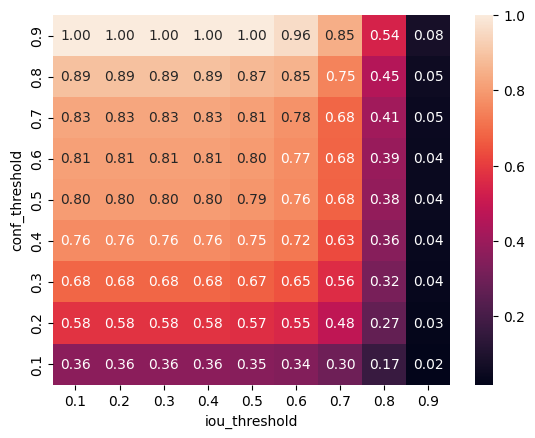

In [56]:
ax = sns.heatmap(
    giardia_df.pivot("conf_threshold", "iou_threshold", "precision"),
    annot=True,
    fmt=".2f",
);
ax.invert_yaxis()


/tmp/ipykernel_30068/731401046.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  giardia_df.pivot("conf_threshold", "iou_threshold", "recall"),


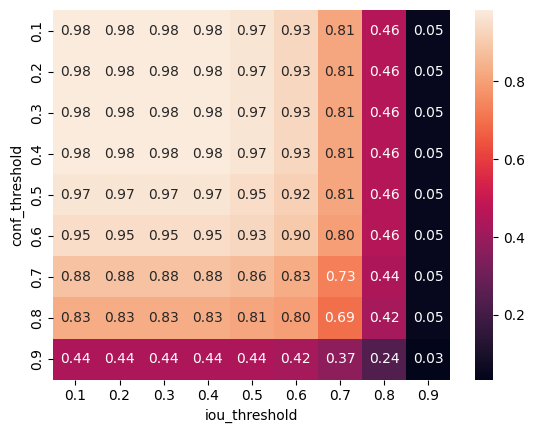

In [57]:
sns.heatmap(
    giardia_df.pivot("conf_threshold", "iou_threshold", "recall"),
    annot=True,
    fmt=".2f",
);

/tmp/ipykernel_30068/2376446955.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  giardia_df.pivot("conf_threshold", "iou_threshold", "f1_score"),


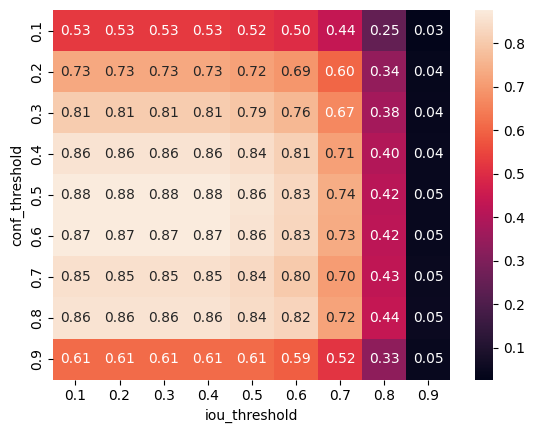

In [58]:
sns.heatmap(
    giardia_df.pivot("conf_threshold", "iou_threshold", "f1_score"),
    annot=True,
    fmt=".2f",
);

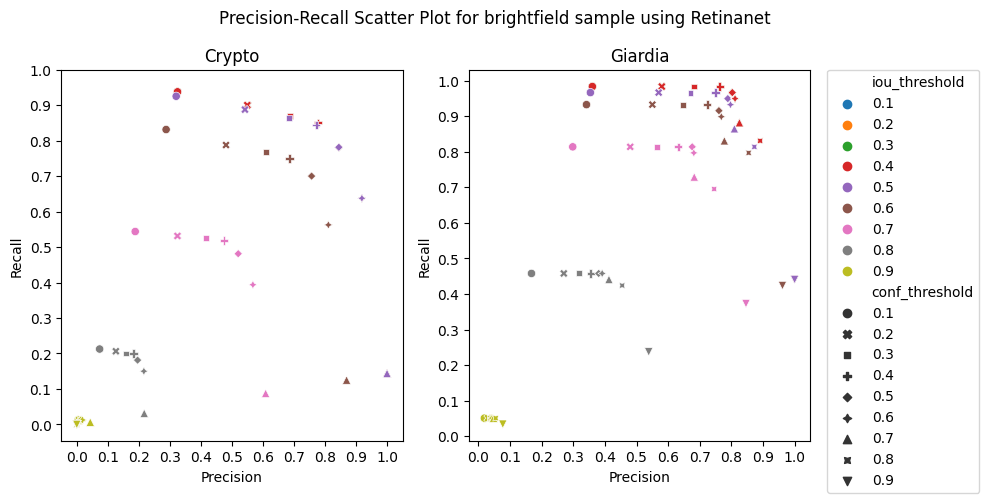

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    f"Precision-Recall Scatter Plot for {sample_type.replace('_', ' ')} using {model_type.replace('_', ' ').capitalize()}"
)

for i in range(2):
    if i == 0:
        category = "Crypto"
    else:
        category = "Giardia"

    ax = sns.scatterplot(
        data=metrics_df[metrics_df["category"] == category],
        x="precision",
        y="recall",
        hue="iou_threshold",
        palette="tab10",
        style="conf_threshold",
        ax=axs[i],
    )
    axs[i].set_title(f"{category.capitalize()}")
    axs[i].set_xlabel("Precision")
    axs[i].set_ylabel("Recall")
    axs[i].set_xticks(np.arange(0, 1.1, 0.1))
    axs[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i == 0:
        axs[i].get_legend().remove()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.tight_layout();